In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

import astropy
from matplotlib.colors import LogNorm
from astropy import units as u
from gala import coordinates as gc
from astropy.coordinates import SkyCoord
from tqdm import tqdm
from astropy.io import ascii
from astropy.coordinates import Angle
from numpy.polynomial.polynomial import polyval,polyfit
import glob
import pandas as pd
import pickle
import scipy
from scipy import stats

import chandra
from chandra import outerhalo as oh
from chandra import plot as chplot
from chandra import gal as chgal

import os

plt.style.use('vedant')
%config InlineBackend.figure_format='retina'

In [2]:
# Sync catalogs

os.system('rsync -vr --progress ody:/n/holyscratch01/conroy_lab/vchandra/sdss5/catalogs/ /Users/vedantchandra/0_research/data/sdss5/mwmhalo/catalogs/')

receiving file list ... 
37 files to consider
mwmhalo_acat_v6_0_9.fits
    24177600 100%  461.15MB/s    0:00:00 (xfer#1, to-check=35/37)
mwmhalo_clean_acat_v6_0_9.fits
    18423360 100%  140.56MB/s    0:00:00 (xfer#2, to-check=34/37)
mwmhalo_xh3_acat_v6_0_9.fits
     1759680 100%   13.01MB/s    0:00:00 (xfer#3, to-check=33/37)
mwmhalo_xh3_rcat_V0.06_MSG.fits
     2246400 100%   15.99MB/s    0:00:00 (xfer#4, to-check=32/37)
spAll-lite-v6_0_9.fits.gz
   413942923 100%  467.18MB/s    0:00:00 (xfer#5, to-check=31/37)
spAll_halo_v6_0_9.fits
     7842240 100%    8.61MB/s    0:00:00 (xfer#6, to-check=30/37)
xgall/mwmhalo_xgall_v6_0_9_0.fits
      426240 100%  477.90kB/s    0:00:00 (xfer#7, to-check=26/37)
xgall/mwmhalo_xgall_v6_0_9_1.fits
      665280 100%  742.50kB/s    0:00:00 (xfer#8, to-check=25/37)
xgall/mwmhalo_xgall_v6_0_9_10.fits
      501120 100%  558.01kB/s    0:00:00 (xfer#9, to-check=24/37)
xgall/mwmhalo_xgall_v6_0_9_11.fits
      262080 100%  291.83kB/s    0:00:00 (xfer#10, to-ch

0

In [3]:
catalog = 'mwmhalo_xh3'
version = 'V0.06'

In [4]:
acat = Table.read('/Users/vedantchandra/0_research/data/sdss5/mwmhalo/catalogs/mwmhalo_acat.fits')

In [5]:
table = Table.read('/Users/vedantchandra/0_research/data/sdss5/mwmhalo/catalogs/%s_rcat_%s_MSG.fits' % (catalog, version))

In [25]:
clean = (

    (table['h3_FLAG'] == 0) & 
    (table['SNR'] > 10) & 
    (table['Teff'] < 6000) &
    (~np.isnan(table['EEP']))

)

print(len(clean))
print(np.sum(clean))

399
193


In [26]:
ekw = dict(linestyle = 'none', marker = 'o', color = 'k', ecolor = 'gray')

In [27]:
fs = 22

In [28]:
def comp(x):
    mins = np.nanmin([np.nanmin(table['h3_' + x][clean]), 
                                 np.nanmin(table[x][clean])])
    maxs = np.nanmax([np.nanmax(table['h3_' + x][clean]), 
                                 np.nanmax(table[x][clean])])
    lims = [mins - 0.1 * np.abs(mins), maxs + 0.1 * np.abs(maxs)]
    
    diff =  table[x][clean] - table['h3_' + x][clean]
    
    mad = np.median(np.abs(diff))
    bias = np.median(diff)

    plt.errorbar(table['h3_' + x][clean], table[x][clean],
                xerr = table['h3_' + x + '_err'][clean], yerr = table[x + '_err'][clean], **ekw)

    plt.plot(lims, lims, 'C3')
    plt.title('MAD: %.2f, Bias: %.2f' % (mad, bias), fontsize = fs)
    
    plt.xlim(lims)
    plt.ylim(lims)
    
    if x == 'Dist':
        plt.xscale('log')
        plt.yscale('log')

In [29]:
table['h3_Dist'] = table['h3_dist_adpt']
table['h3_Dist_err'] = table['h3_dist_adpt_err']

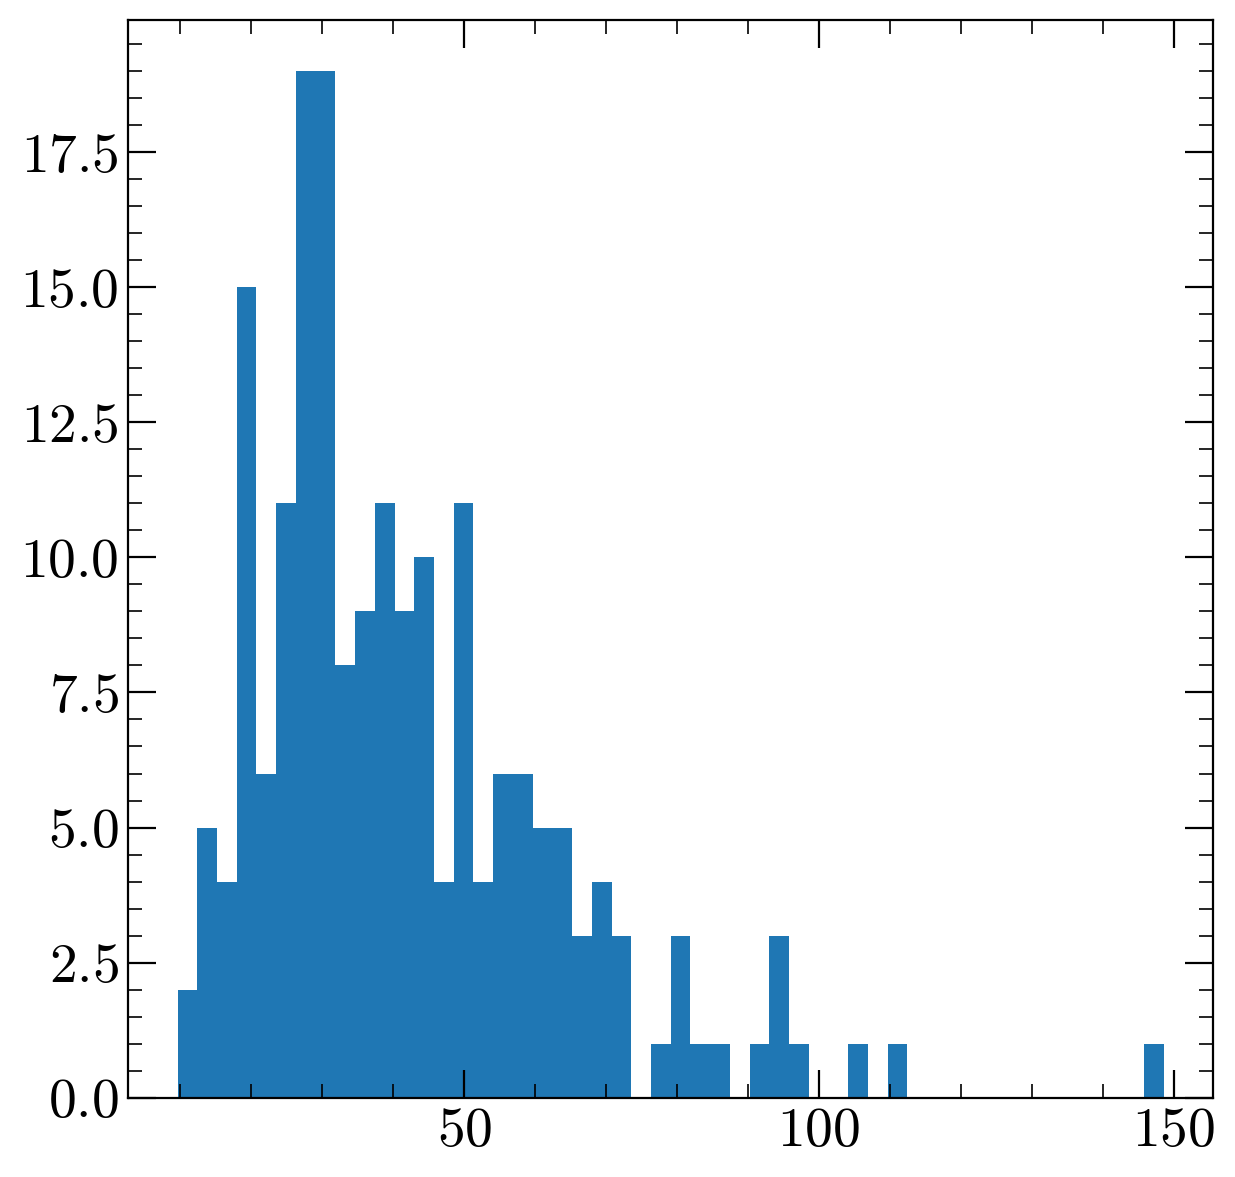

In [30]:
plt.hist(table[clean]['Vrot'], bins = 50);

In [ ]:
f,axs = plt.subplots(3,3,figsize = (15, 15))
axr = axs.ravel()

labels = ['Teff', 'logg', 'FeH', 'aFe', 'Dist', 'Vrad', 'Av', 'Vrot', 'EEP']

for ii in range(len(labels)):
    plt.sca(axr[ii])
    comp(labels[ii])
    
    plt.xlabel('H3 ' + labels[ii], fontsize = fs)
    plt.ylabel('MWM ' + labels[ii], fontsize = fs)
    
plt.tight_layout()

plt.savefig('fig/mwm_h3_comparison_%s.png' % version)

Text(0, 0.5, 'FeH bias')

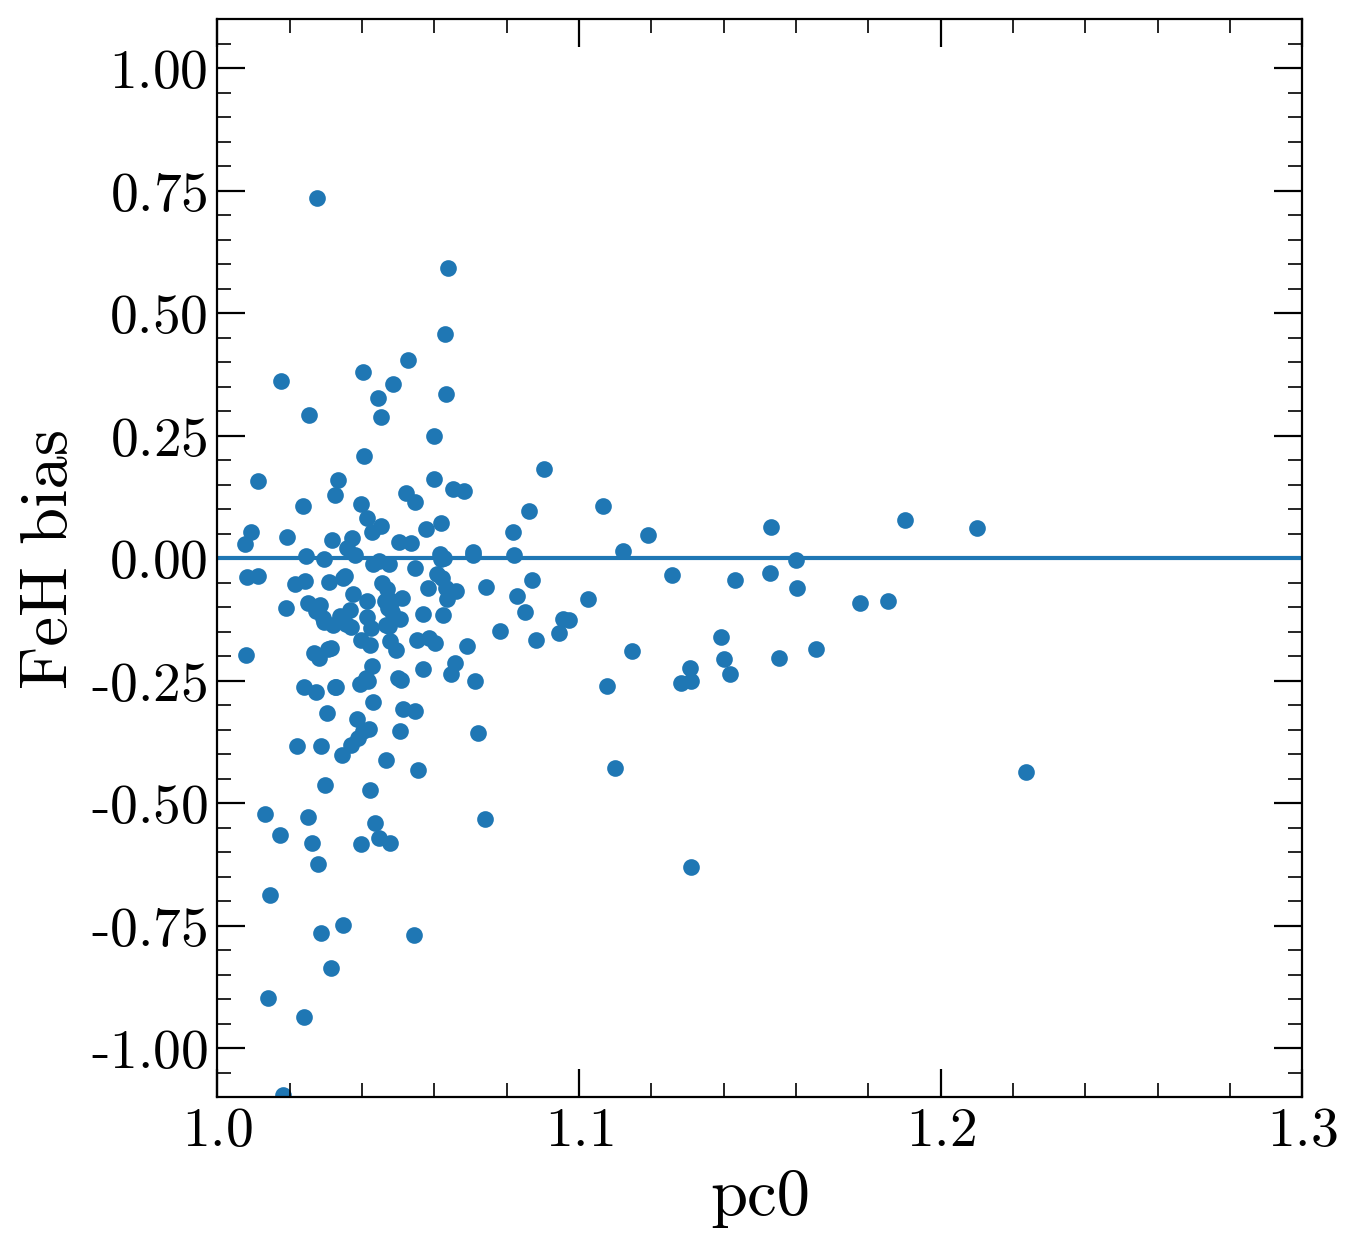

In [32]:
plt.scatter(table[clean]['pc_0'], table[clean]['FeH'] - table[clean]['h3_FeH'])
plt.xlim(1, 1.3)
plt.ylim(-1.1, 1.1)

plt.axhline(0)

plt.xlabel('pc0')
plt.ylabel('FeH bias')

Text(0, 0.5, '# of stars')

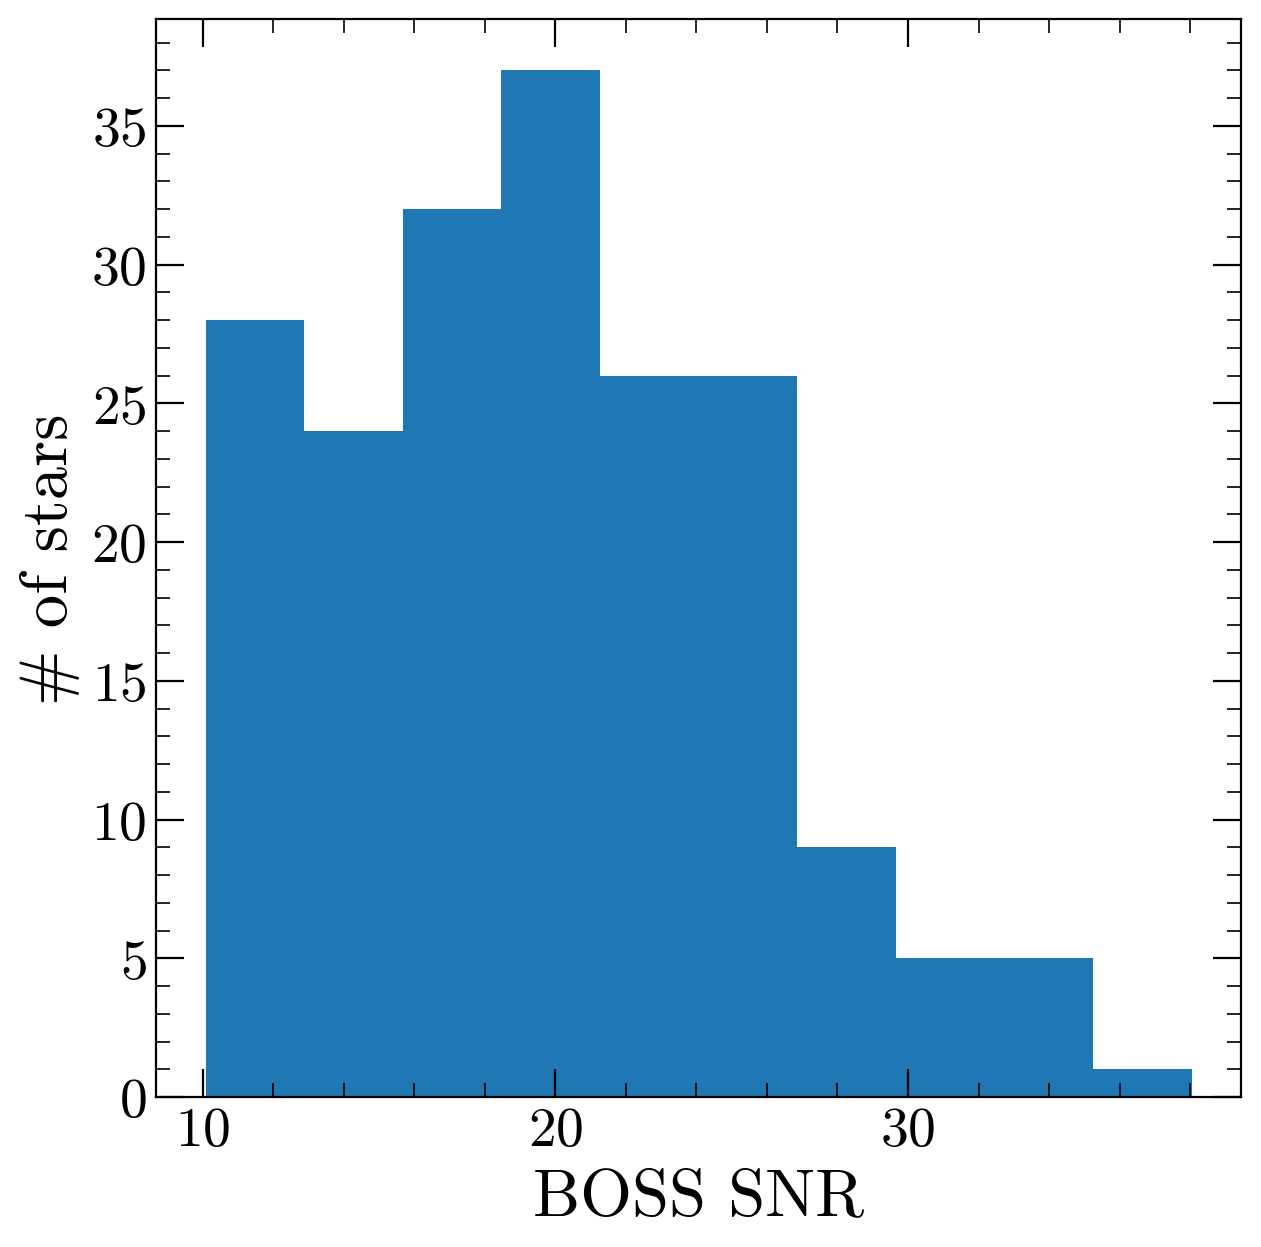

In [33]:
plt.hist(table['SNR'][clean])
plt.xlabel('BOSS SNR')
plt.ylabel('# of stars')

In [48]:
# Sync plots

os.system('rsync -vzr --progress ody:/n/holyscratch01/conroy_lab/vchandra/sdss5/plots/mwmhalo_xh3 /Users/vedantchandra/0_research/data/sdss5/mwmhalo/plots/')

receiving file list ... 
773 files to consider
mwmhalo_xh3/=V0.02/
mwmhalo_xh3/=V0.02/mwm_gaiaID_1062337590613157760_fieldID_100818_mjd_59657_catID_27021597913598259_=V0.02_compmod.png
      543295 100%  978.90kB/s    0:00:00 (xfer#1, to-check=770/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_1062337590613157760_fieldID_100818_mjd_59657_catID_27021597913598259_=V0.02_corner.png
      954928 100%  931.62kB/s    0:00:01 (xfer#2, to-check=769/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_1062399025825382784_fieldID_100818_mjd_59657_catID_27021597913598530_=V0.02_compmod.png
      600484 100%    2.47MB/s    0:00:00 (xfer#3, to-check=768/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_1062399025825382784_fieldID_100818_mjd_59657_catID_27021597913598530_=V0.02_corner.png
      921508 100%    1.80MB/s    0:00:00 (xfer#4, to-check=767/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_1064217858576389888_fieldID_102959_mjd_59690_catID_27021597914434578_=V0.02_compmod.png
      636308 100%  954.52kB/s    0:00:00 (xfer#5, to-check=766/773)
mwmha

      951585 100%  864.45kB/s    0:00:01 (xfer#44, to-check=727/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3637697936613780480_fieldID_103284_mjd_59645_catID_27021598146861639_=V0.02_compmod.png
      565360 100%    3.17MB/s    0:00:00 (xfer#45, to-check=726/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3637697936613780480_fieldID_103284_mjd_59645_catID_27021598146861639_=V0.02_corner.png
      951088 100%    2.80MB/s    0:00:00 (xfer#46, to-check=725/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3651914999918124160_fieldID_102347_mjd_59731_catID_27021598157821422_=V0.02_compmod.png
      686217 100%    1.47MB/s    0:00:00 (xfer#47, to-check=724/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3651914999918124160_fieldID_102347_mjd_59731_catID_27021598157821422_=V0.02_corner.png
      910448 100%    1.45MB/s    0:00:00 (xfer#48, to-check=723/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3651966161568658176_fieldID_102347_mjd_59731_catID_27021598157823944_=V0.02_compmod.png
      602155 100%  829.40kB/s    0:00:00 (xfer#49, to-check=722/773

      821670 100%    1.00MB/s    0:00:00 (xfer#88, to-check=683/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3798313426967745536_fieldID_101212_mjd_59676_catID_27021598151748946_=V0.02_compmod.png
      551667 100%  588.14kB/s    0:00:00 (xfer#89, to-check=682/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3798313426967745536_fieldID_101212_mjd_59676_catID_27021598151748946_=V0.02_corner.png
      927352 100%  847.16kB/s    0:00:01 (xfer#90, to-check=681/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3798347619203106432_fieldID_101212_mjd_59676_catID_27021598151756239_=V0.02_compmod.png
      641225 100%    3.42MB/s    0:00:00 (xfer#91, to-check=680/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3798347619203106432_fieldID_101212_mjd_59676_catID_27021598151756239_=V0.02_corner.png
      942849 100%    1.98MB/s    0:00:00 (xfer#92, to-check=679/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3798533093070802560_fieldID_101212_mjd_59676_catID_27021598151752565_=V0.02_compmod.png
      635180 100%  517.34kB/s    0:00:01 (xfer#93, to-check=678/773

      928477 100%    1.67MB/s    0:00:00 (xfer#132, to-check=639/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59704_catID_27021598151242606_=V0.02_compmod.png
      640288 100%  944.53kB/s    0:00:00 (xfer#133, to-check=638/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59704_catID_27021598151242606_=V0.02_corner.png
      917183 100%    1.06MB/s    0:00:00 (xfer#134, to-check=637/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59702_catID_27021598151244151_=V0.02_compmod.png
      678560 100%  699.74kB/s    0:00:00 (xfer#135, to-check=636/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59702_catID_27021598151244151_=V0.02_corner.png
      742771 100%  668.54kB/s    0:00:01 (xfer#136, to-check=635/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59704_catID_27021598151244151_=V0.02_compmod.png
      646520 100%    3.39MB/s    0:00:00 (xfer#137, to-check=6

      894279 100%    5.05MB/s    0:00:00 (xfer#176, to-check=595/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59722_catID_27021598333201510_=V0.02_compmod.png
      609004 100%    2.12MB/s    0:00:00 (xfer#177, to-check=594/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59722_catID_27021598333201510_=V0.02_corner.png
      948559 100%    2.19MB/s    0:00:00 (xfer#178, to-check=593/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59723_catID_27021598333201510_=V0.02_compmod.png
      782408 100%    1.30MB/s    0:00:00 (xfer#179, to-check=592/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59723_catID_27021598333201510_=V0.02_corner.png
      884839 100%    1.18MB/s    0:00:00 (xfer#180, to-check=591/773)
mwmhalo_xh3/=V0.02/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59731_catID_27021598333201510_=V0.02_compmod.png
      660144 100%  791.98kB/s    0:00:00 (xfer#181, to-check=5

mwmhalo_xh3/V0.0/mwm_gaiaID_3637676775309933568_fieldID_103284_mjd_59643_catID_27021598146861129_V0.0_corner.png
      936291 100%    1.63MB/s    0:00:00 (xfer#224, to-check=546/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3637676775309933568_fieldID_103284_mjd_59645_catID_27021598146861129_V0.0_compmod.png
      581493 100% 1023.18kB/s    0:00:00 (xfer#225, to-check=545/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3637676775309933568_fieldID_103284_mjd_59645_catID_27021598146861129_V0.0_corner.png
      938649 100%    1.59MB/s    0:00:00 (xfer#226, to-check=544/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3637682204148643072_fieldID_103284_mjd_59643_catID_27021598146861459_V0.0_compmod.png
      675437 100%    1.14MB/s    0:00:00 (xfer#227, to-check=543/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3637682204148643072_fieldID_103284_mjd_59643_catID_27021598146861459_V0.0_corner.png
      947993 100%    1.59MB/s    0:00:00 (xfer#228, to-check=542/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3637682204148643072_fieldID_103284_mjd_59645_catID_2702

mwmhalo_xh3/V0.0/mwm_gaiaID_3781818313009621120_fieldID_101254_mjd_59658_catID_27021598130969548_V0.0_compmod.png
      605010 100%    1.03MB/s    0:00:00 (xfer#273, to-check=497/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3781818313009621120_fieldID_101254_mjd_59658_catID_27021598130969548_V0.0_corner.png
      869212 100%    1.46MB/s    0:00:00 (xfer#274, to-check=496/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3793721698907214080_fieldID_102883_mjd_59645_catID_27021598131859946_V0.0_compmod.png
      610615 100%    1.01MB/s    0:00:00 (xfer#275, to-check=495/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3793721698907214080_fieldID_102883_mjd_59645_catID_27021598131859946_V0.0_corner.png
      993285 100%    1.62MB/s    0:00:00 (xfer#276, to-check=494/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3793774509825097728_fieldID_102883_mjd_59645_catID_27021598131861440_V0.0_compmod.png
      624156 100%    1.01MB/s    0:00:00 (xfer#277, to-check=493/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3793774509825097728_fieldID_102883_mjd_59645_catID_270

mwmhalo_xh3/V0.0/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59702_catID_27021598151242606_V0.0_compmod.png
      665581 100%  469.30kB/s    0:00:01 (xfer#323, to-check=447/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59702_catID_27021598151242606_V0.0_corner.png
      944691 100%   53.00MB/s    0:00:00 (xfer#324, to-check=446/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59704_catID_27021598151242606_V0.0_compmod.png
      591738 100%   22.57MB/s    0:00:00 (xfer#325, to-check=445/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59704_catID_27021598151242606_V0.0_corner.png
      942472 100%   28.99MB/s    0:00:00 (xfer#326, to-check=444/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59702_catID_27021598151244151_V0.0_compmod.png
      718667 100%   18.52MB/s    0:00:00 (xfer#327, to-check=443/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59702_catID_270

mwmhalo_xh3/V0.0/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59731_catID_27021598333201510_V0.0_compmod.png
      671784 100%    1.15MB/s    0:00:00 (xfer#373, to-check=397/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59731_catID_27021598333201510_V0.0_corner.png
      935532 100%    1.58MB/s    0:00:00 (xfer#374, to-check=396/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59671_catID_27021598333202921_V0.0_compmod.png
      779487 100%    1.30MB/s    0:00:00 (xfer#375, to-check=395/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59671_catID_27021598333202921_V0.0_corner.png
      884090 100%    1.45MB/s    0:00:00 (xfer#376, to-check=394/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59722_catID_27021598333202921_V0.0_compmod.png
      631403 100%    1.02MB/s    0:00:00 (xfer#377, to-check=393/773)
mwmhalo_xh3/V0.0/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59722_catID_270

mwmhalo_xh3/V0.01/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59643_catID_27021598146861395_V0.01_compmod.png
      655326 100%    1.63MB/s    0:00:00 (xfer#423, to-check=346/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59643_catID_27021598146861395_V0.01_corner.png
      952998 100%    2.33MB/s    0:00:00 (xfer#424, to-check=345/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59645_catID_27021598146861395_V0.01_compmod.png
      600554 100%    1.45MB/s    0:00:00 (xfer#425, to-check=344/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59645_catID_27021598146861395_V0.01_corner.png
      947116 100%    2.24MB/s    0:00:00 (xfer#426, to-check=343/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3637697936613780480_fieldID_103284_mjd_59643_catID_27021598146861639_V0.01_compmod.png
      662479 100%    1.54MB/s    0:00:00 (xfer#427, to-check=342/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3637697936613780480_fieldID_103284_mjd_5964

mwmhalo_xh3/V0.01/mwm_gaiaID_3796542702146752000_fieldID_102882_mjd_59647_catID_27021598131723453_V0.01_corner.png
      801874 100%  819.12kB/s    0:00:00 (xfer#472, to-check=297/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3798313426967745536_fieldID_101212_mjd_59676_catID_27021598151748946_V0.01_compmod.png
      588408 100%  596.69kB/s    0:00:00 (xfer#473, to-check=296/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3798313426967745536_fieldID_101212_mjd_59676_catID_27021598151748946_V0.01_corner.png
      947655 100%  952.10kB/s    0:00:00 (xfer#474, to-check=295/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3798347619203106432_fieldID_101212_mjd_59676_catID_27021598151756239_V0.01_compmod.png
      656833 100%  655.87kB/s    0:00:00 (xfer#475, to-check=294/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3798347619203106432_fieldID_101212_mjd_59676_catID_27021598151756239_V0.01_corner.png
      930150 100%  922.18kB/s    0:00:00 (xfer#476, to-check=293/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3798533093070802560_fieldID_101212_mjd_59676

mwmhalo_xh3/V0.01/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59702_catID_27021598151244151_V0.01_corner.png
      813010 100%  893.09kB/s    0:00:00 (xfer#520, to-check=249/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59704_catID_27021598151244151_V0.01_compmod.png
      675518 100%  731.36kB/s    0:00:00 (xfer#521, to-check=248/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3807219230634581376_fieldID_101253_mjd_59704_catID_27021598151244151_V0.01_corner.png
      959385 100% 1022.82kB/s    0:00:00 (xfer#522, to-check=247/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3807225346668511872_fieldID_101253_mjd_59702_catID_27021598151244314_V0.01_compmod.png
      677232 100%  718.09kB/s    0:00:00 (xfer#523, to-check=246/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3807225346668511872_fieldID_101253_mjd_59702_catID_27021598151244314_V0.01_corner.png
      948994 100% 1001.89kB/s    0:00:00 (xfer#524, to-check=245/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_3807225346668511872_fieldID_101253_mjd_59704

mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59722_catID_27021598333202921_V0.01_compmod.png
      758024 100%    1.98MB/s    0:00:00 (xfer#569, to-check=200/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59722_catID_27021598333202921_V0.01_corner.png
      940803 100%    2.39MB/s    0:00:00 (xfer#570, to-check=199/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59723_catID_27021598333202921_V0.01_compmod.png
      866954 100%    2.16MB/s    0:00:00 (xfer#571, to-check=198/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59723_catID_27021598333202921_V0.01_corner.png
      942231 100%    2.30MB/s    0:00:00 (xfer#572, to-check=197/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_59731_catID_27021598333202921_V0.01_compmod.png
      774247 100%    1.86MB/s    0:00:00 (xfer#573, to-check=196/773)
mwmhalo_xh3/V0.01/mwm_gaiaID_6340567653950261248_fieldID_102329_mjd_5973

      970217 100%    3.52MB/s    0:00:00 (xfer#614, to-check=154/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59643_catID_27021598146861395_V0.03_compmod.png
      716279 100%    2.08MB/s    0:00:00 (xfer#615, to-check=153/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59643_catID_27021598146861395_V0.03_corner.png
      965002 100%    1.93MB/s    0:00:00 (xfer#616, to-check=152/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59645_catID_27021598146861395_V0.03_compmod.png
      575731 100%    1.01MB/s    0:00:00 (xfer#617, to-check=151/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3637695256554169216_fieldID_103284_mjd_59645_catID_27021598146861395_V0.03_corner.png
      937560 100%    1.21MB/s    0:00:00 (xfer#618, to-check=150/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3637697936613780480_fieldID_103284_mjd_59643_catID_27021598146861639_V0.03_compmod.png
      655216 100%  799.82kB/s    0:00:00 (xfer#619, to-check=149/773)
mw

      597191 100%    1.03MB/s    0:00:00 (xfer#659, to-check=109/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3793721698907214080_fieldID_102883_mjd_59645_catID_27021598131859946_V0.03_corner.png
      952499 100%    1.28MB/s    0:00:00 (xfer#660, to-check=108/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3793774509825097728_fieldID_102883_mjd_59645_catID_27021598131861440_V0.03_compmod.png
      701930 100%  856.85kB/s    0:00:00 (xfer#661, to-check=107/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3793774509825097728_fieldID_102883_mjd_59645_catID_27021598131861440_V0.03_corner.png
      924176 100%  998.36kB/s    0:00:00 (xfer#662, to-check=106/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3796542702146752000_fieldID_102882_mjd_59647_catID_27021598131723453_V0.03_compmod.png
      673033 100%  643.11kB/s    0:00:01 (xfer#663, to-check=105/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3796542702146752000_fieldID_102882_mjd_59647_catID_27021598131723453_V0.03_corner.png
      798985 100%    5.25MB/s    0:00:00 (xfer#664, to-check=104/773)
mwm

      811901 100%    1.18MB/s    0:00:00 (xfer#704, to-check=64/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3807212637860169728_fieldID_101253_mjd_59704_catID_27021598151244744_V0.03_compmod.png
      599091 100%  773.88kB/s    0:00:00 (xfer#705, to-check=63/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3807212637860169728_fieldID_101253_mjd_59704_catID_27021598151244744_V0.03_corner.png
      924087 100%  956.98kB/s    0:00:00 (xfer#706, to-check=62/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59702_catID_27021598151242606_V0.03_compmod.png
      687444 100%  638.15kB/s    0:00:01 (xfer#707, to-check=61/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59702_catID_27021598151242606_V0.03_corner.png
      977932 100%    5.52MB/s    0:00:00 (xfer#708, to-check=60/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_3807218165482685696_fieldID_101253_mjd_59704_catID_27021598151242606_V0.03_compmod.png
      673809 100%    2.59MB/s    0:00:00 (xfer#709, to-check=59/773)
mwmhalo_

      620692 100%  688.02kB/s    0:00:00 (xfer#749, to-check=19/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_4418031479264472448_fieldID_102329_mjd_59674_catID_27021598333237759_V0.03_corner.png
      778907 100%  765.24kB/s    0:00:00 (xfer#750, to-check=18/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59671_catID_27021598333201510_V0.03_compmod.png
      625479 100%  542.95kB/s    0:00:01 (xfer#751, to-check=17/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59671_catID_27021598333201510_V0.03_corner.png
      931564 100%    3.40MB/s    0:00:00 (xfer#752, to-check=16/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59722_catID_27021598333201510_V0.03_compmod.png
      613334 100%    1.69MB/s    0:00:00 (xfer#753, to-check=15/773)
mwmhalo_xh3/V0.03/mwm_gaiaID_6339792773131032960_fieldID_102329_mjd_59722_catID_27021598333201510_V0.03_corner.png
      953869 100%    1.91MB/s    0:00:00 (xfer#754, to-check=14/773)
mwmhalo_x

0